Dataset : https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/data?select=2019-Oct.csv

In [1]:
import pandas as pd

#### Load & Inspect the Data

In [2]:
data= pd.read_csv("C:/Users/sweth/Downloads/2019-Oct.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [4]:
data.shape

(42448764, 9)

In [5]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


#### Clean & Preprocess the data

We'll convert timestamps, sort the data chronologically, and extract useful features like hour and weekday.

In [6]:
# Convert timestamp column
data['event_time']=pd.to_datetime(data['event_time'])

#Sort chronologically 
data=data.sort_values(by='event_time')

#Extract hour & weekday
data['hour']=data['event_time'].dt.hour
data['day']=data['event_time'].dt.day_name()

data[['event_time','hour','day']].head()

,event_time,hour,day
0,2019-10-01 00:00:00+00:00,0,Tuesday
1,2019-10-01 00:00:00+00:00,0,Tuesday
2,2019-10-01 00:00:01+00:00,0,Tuesday
3,2019-10-01 00:00:01+00:00,0,Tuesday
4,2019-10-01 00:00:04+00:00,0,Tuesday


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42448764 entries, 0 to 42448763
Data columns (total 11 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
 9   hour           int32              
 10  day            object             
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(3), object(5)
memory usage: 3.6+ GB


#### Event Funnel Conversion Rate

We’ll calculate how many users perform each type of event and analyze overall conversion from view → cart → purchase.

In [9]:
funnel_counts=data.groupby('event_type')['user_id'].nunique() #unique users per event type
funnel_counts=funnel_counts[['view','cart','purchase']] #keeping in order
funnel_counts

event_type
view        3022130
cart         337117
purchase     347118
Name: user_id, dtype: int64

In [10]:
#Conversion rates
view_to_cart= funnel_counts['cart']/funnel_counts['view']
cart_to_purchase= funnel_counts['purchase']/funnel_counts['cart']
view_to_purchase= funnel_counts['purchase']/funnel_counts['view']

print("View->Cart: ",round(view_to_cart*100,2),"%")
print("Cart->Purchase: ",round(cart_to_purchase*100,2),"%")
print("View->Purchase: ",round(view_to_purchase*100,2),"%")

View->Cart:  11.15 %
Cart->Purchase:  102.97 %
View->Purchase:  11.49 %


#### Event Distribution over time

Let's check how events are distributed across hours of the day.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
data['hour'] = data['hour'].astype('int8') #saving memory

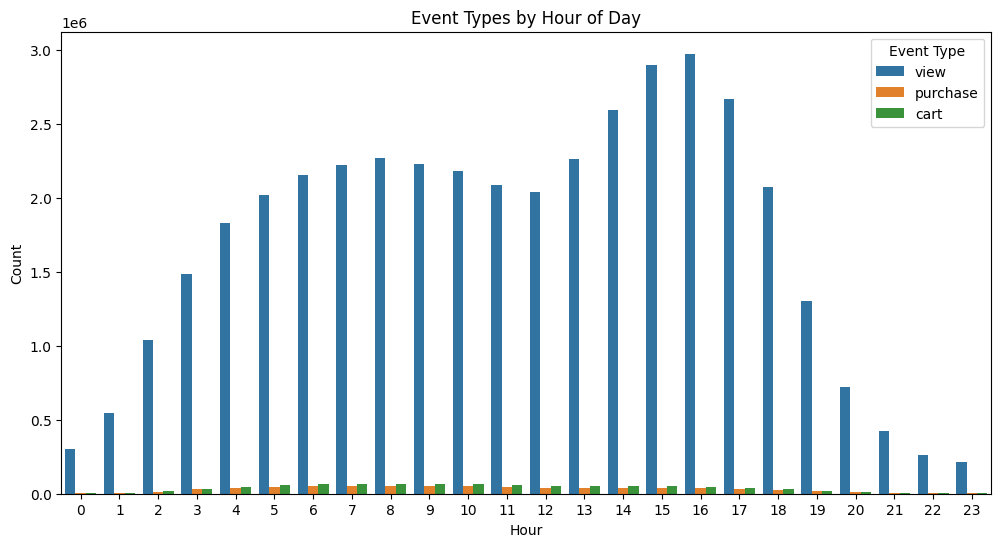

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='hour', hue='event_type', order=range(24))
plt.title("Event Types by Hour of Day")
plt.ylabel("Count")
plt.xlabel("Hour")
plt.legend(title="Event Type")
plt.show()

#### Session Funnel Breakdown

We’ll group by session to analyze which combinations of actions occur within sessions.

In [15]:
#set of events per session
session_funnels= data.groupby('user_session')['event_type'].apply(set)
session_funnels= session_funnels.value_counts()
session_funnels

event_type
{view}                    8333625
{view, purchase}           337121
{cart, view, purchase}     291500
{cart, view}               280407
{cart}                        829
{purchase}                    578
{cart, purchase}              361
Name: count, dtype: int64

#### Product Funnel Breakdown by Category

Going beyond top-level funnel metrics and exploring which product categories are converting well or poorly. 
This helps identify high-leverage areas for product or marketing teams to focus on.

In [16]:
category_funnel= data.groupby(['category_code','event_type'])['user_id'].nunique().unstack().fillna(0)

#unstack() : This pivots the inner index level (event_type) to columns, turning the Series into a DataFrame.

In [17]:
#Category level conversion

category_funnel['view_to_cart']=category_funnel['cart']/category_funnel['view']
category_funnel['cart_to_purchase']=category_funnel['purchase']/category_funnel['cart']
category_funnel['view_to_purchase']=category_funnel['purchase']/category_funnel['view']

#sort
category_funnel=category_funnel.sort_values(by='view_to_purchase',ascending=False)
category_funnel[['view','cart','purchase','view_to_cart','cart_to_purchase','view_to_purchase']].head(10)

event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
category_code,,,,,,
electronics.smartphone,1300070.0,198347.0,160437.0,0.152566,0.808870,0.123406
appliances.iron,29626.0,2199.0,2948.0,0.074225,1.340609,0.099507
appliances.environment.air_heater,19033.0,1322.0,1819.0,0.069458,1.375946,0.095571
appliances.environment.water_heater,23744.0,1813.0,2132.0,0.076356,1.175951,0.089791
electronics.audio.headphone,213948.0,22482.0,18826.0,0.105082,0.837381,0.087993
appliances.kitchen.microwave,35935.0,2543.0,2949.0,0.070767,1.159654,0.082065
appliances.personal.scales,13458.0,819.0,1083.0,0.060856,1.322344,0.080473
appliances.kitchen.washer,132028.0,9948.0,10480.0,0.075348,1.053478,0.079377
electronics.video.tv,170044.0,16672.0,13476.0,0.098045,0.808301,0.079250


#### Key Visualizations

To help stakeholders interpret the analysis quickly, we’ll visualize:
1. Top product categories by conversion
2. Purchase activity by hour of day

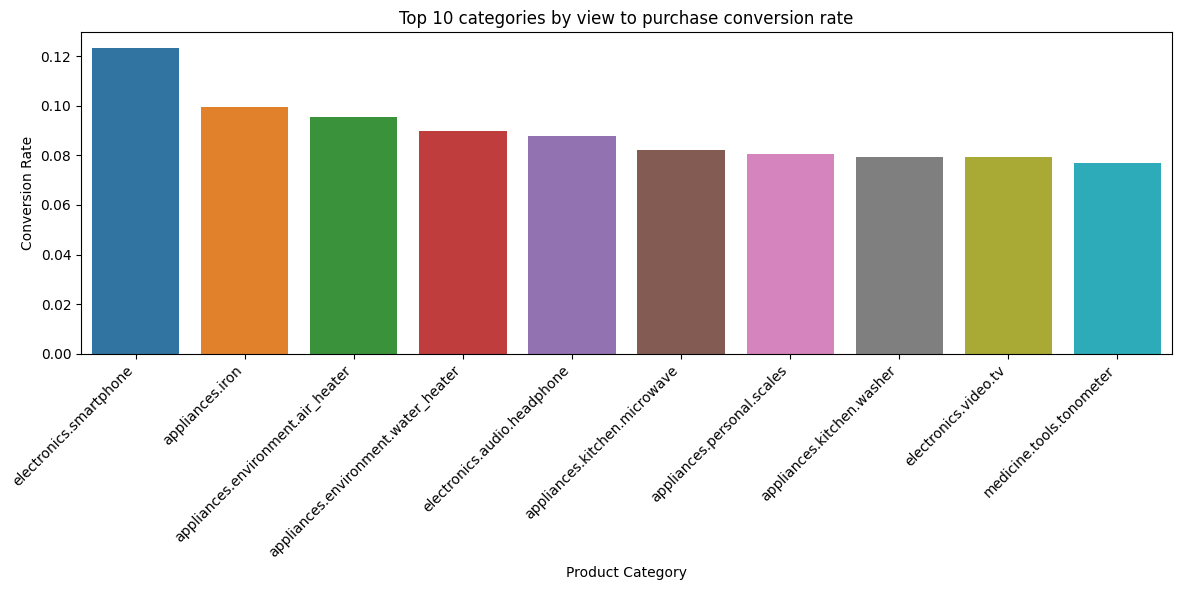

In [28]:
top_cats=category_funnel.sort_values(by='view_to_purchase',ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_cats,x=top_cats.index,y=top_cats['view_to_purchase'],hue='category_code')
plt.xlabel('Product Category')
plt.ylabel('Conversion Rate')
plt.title('Top 10 categories by view to purchase conversion rate')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

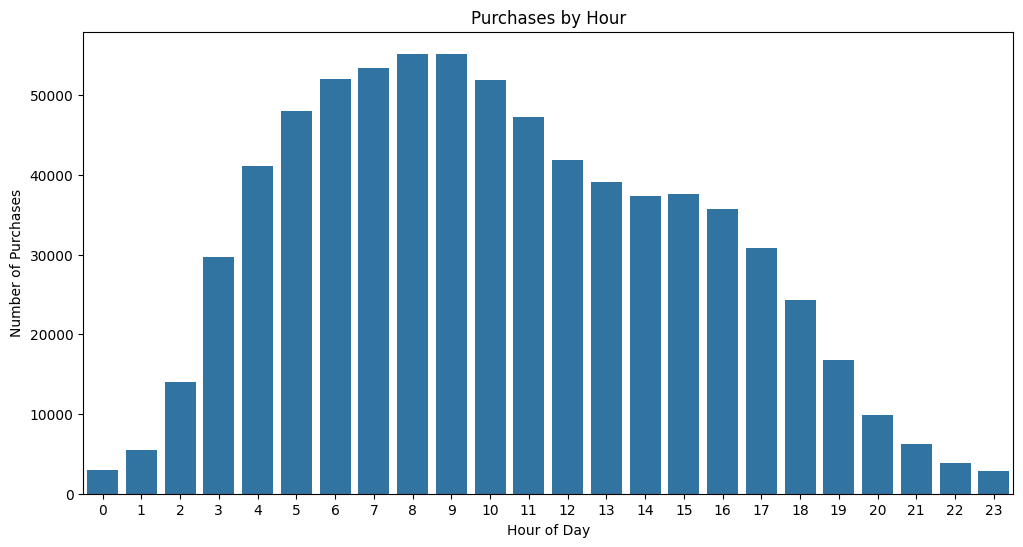

In [32]:
purchase_df = data[data['event_type'] == 'purchase']

plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=purchase_df)
plt.title('Purchases by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.show()